In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import label
from tqdm import tqdm

# Configuration
DIM = 3
POWER = 4
MAX_STEPS = POWER + 5

def generate_percolation_lattice(size, p):
    return np.random.choice([0, 1], (size, size), p=[1-p, p]).astype(np.uint8)

def check_percolation(lattice):
    labeled, _ = label(lattice)
    top = set(labeled[0]) - {0}
    bottom = set(labeled[-1]) - {0}
    left = set(labeled[:,0]) - {0}
    right = set(labeled[:,-1]) - {0}
    return float(bool(top & bottom) or bool(left & right))

# --- Percolation Probability Utilities ---
def _precompute_coeffs(dim):
    """
    Compute percolating-configuration counts for a dim x dim lattice.
    """
    N = dim * dim
    coeffs = np.zeros(N + 1, dtype=int)
    for mask in range(1 << N):
        bits = [(mask >> i) & 1 for i in range(N)]
        grid = np.array(bits, dtype=bool).reshape(dim, dim)
        if check_percolation(grid):  # use existing function
            coeffs[sum(bits)] += 1
    return coeffs

# Precompute and cache for dims 3 and 4
def _build_coeff_cache(dims=(3, 4)):
    return {d: _precompute_coeffs(d) for d in dims}

_COEFFS = _build_coeff_cache()


def percolation_probability(dim, p):
    """
    Exact site-percolation probability for a dim x dim lattice,
    where each site is open with probability p.
    Uses cached percolation counts from _COEFFS.
    """
    coeffs = _COEFFS.get(dim)
    if coeffs is None:
        raise ValueError(f"Coefficients for dim={dim} not precomputed.")
    N = dim * dim
    k = np.arange(N + 1)
    # sum C_k * p^k * (1-p)^(N-k)
    probs = coeffs * (p ** k) * ((1 - p) ** (N - k))
    return float(probs.sum())

def first_coarse_graining(binary_lattice, dim):
    """
    Coarse-grains a fine grid of site probabilities by averaging over patches,
    and maps each coarse-grained value to a percolation probability
    for a perc_dim x perc_dim lattice.

    Parameters:
    - grid: 2D numpy array of site probabilities (float values in [0, 1])
    - dim : base of the lattice

    Returns:
    - 2D numpy array of percolation probabilities (coarse-grained)
    """
    t = torch.tensor(binary_lattice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    patches = F.unfold(t, kernel_size=dim, stride=dim)             # [1, dim*dim, num_patches]
    patches = patches.permute(0, 2, 1)                              # [1, num_patches, dim*dim]
    coarse_vals = patches.mean(dim=2)                               # [1, num_patches]

    # Apply percolation_probability to each patch mean
    coarse_final = torch.tensor(
        [[percolation_probability(dim, float(p)) for p in coarse_vals[0]]],
        dtype=torch.float32
    )  # [1, num_patches]

    H, W = binary_lattice.shape
    new_h, new_w = H // dim, W // dim
    return coarse_final.view(1, new_h, new_w)        


class PercolationModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.rule = nn.Sequential(
            nn.Linear(dim * dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, max_steps=MAX_STEPS):
        b, c, H, W = x.shape
        for _ in range(max_steps):
            if H < self.dim or W < self.dim:
                break
            patches = F.unfold(x, kernel_size=self.dim, stride=self.dim)  # [b, dim*dim, np]
            patches = patches.permute(0, 2, 1).contiguous()               # [b, np, dim*dim]
            out = self.rule(patches.view(-1, self.dim*self.dim))          # [b*np, 1]
            new_h, new_w = H // self.dim, W // self.dim
            x = out.view(b, 1, new_h, new_w)
            _, _, H, W = x.shape
        return x.squeeze(1).view(b, -1)  # returns shape [b, new_h*new_w] or [b] if fully reduced

def prepare_dataset(N, size):
    data = []
    for _ in tqdm(range(N), desc="Generating data"):
        p = np.random.uniform(0.1, 0.9)
        L = generate_percolation_lattice(size, p)
        data.append((L, check_percolation(L)))
    return data

def train_epoch(model, device, data, batch_size, opt, crit):
    model.train()
    total_loss = 0.0
    for i in tqdm(range(0, len(data), batch_size), desc="Training"):
        batch = data[i:i+batch_size]
        lattices = [first_coarse_graining(x, DIM) for x, _ in batch]  # list of [1,H',W']
        inputs = torch.stack(lattices).to(device)                     # [B,1,H',W']
        targets = torch.tensor([y for _, y in batch], dtype=torch.float32, device=device)
        
        opt.zero_grad()
        outputs = model(inputs)                                       # [B] or [B,1]
        loss = crit(outputs.view(-1), targets)
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(batch)
    return total_loss / len(data)

def evaluate(model, device, data):
    model.eval()
    correct = 0
    with torch.no_grad():
        for L, lbl in tqdm(data, desc="Evaluating"):
            t = first_coarse_graining(L, DIM).to(device).unsqueeze(0)  # [1,1,H',W']
            out = model(t).item()
            pred = (out > 0.5)
            correct += (pred == bool(lbl))
    return correct / len(data)

In [2]:
# ----------------- Run -----------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SIZE = DIM ** POWER
train_data = prepare_dataset(8_000, SIZE)

model = PercolationModel(DIM).to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.BCELoss()

for epoch in range(1, 6):
    loss = train_epoch(model, DEVICE, train_data, 10, opt, crit)
    print(f"Epoch {epoch} — Loss: {loss:.4f}")

Training: 100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [01:22<00:00,  9.69it/s]


Epoch 1 — Loss: 0.6734


Training: 100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [01:32<00:00,  8.66it/s]


Epoch 2 — Loss: 0.4817


Training: 100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [01:24<00:00,  9.42it/s]


Epoch 3 — Loss: 0.2554


Training: 100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [01:26<00:00,  9.29it/s]


Epoch 4 — Loss: 0.2045


Training: 100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [01:28<00:00,  9.07it/s]

Epoch 5 — Loss: 0.1786


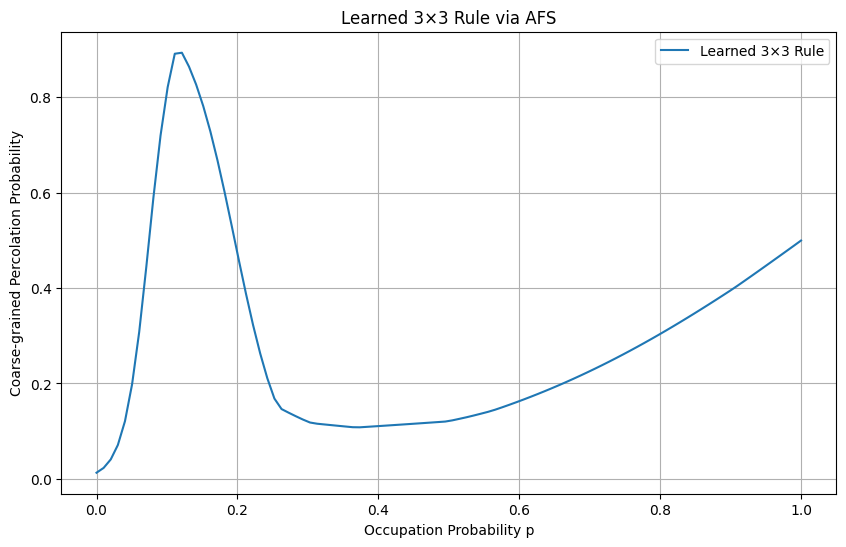

In [3]:
# Visualization

def visualize_rule(model, dim, device='cpu'):
    import matplotlib.pyplot as plt
    p_values = np.linspace(0, 1, 100)
    model.eval()
    rule_predictions = []

    with torch.no_grad():
        for p in p_values:
            # Use a full dim×dim block to query the learned rule
            input_block = torch.full((1, 1, dim, dim), p, device=device, dtype=torch.float32)
            pred = model(input_block).item()
            rule_predictions.append(pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(p_values, rule_predictions, label=f'Learned {dim}×{dim} Rule')
    plt.xlabel('Occupation Probability p')
    plt.ylabel('Coarse-grained Percolation Probability')
    plt.title(f'Learned {dim}×{dim} Rule via AFS')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Learned_{dim}x{dim}_Rule_via_AFS.pdf')
    plt.show()

# Call it
visualize_rule(model, DIM, DEVICE)
